<a href="https://colab.research.google.com/github/pryplotsky/C5.-Deep-Survival-Analysis-and-Time-Varying-Covariates/blob/main/CPH005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cox Time model is taken from:
https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html

In [1]:
#Some basic istructions:
# 1. Each line of code must be FULLY DOCUMENTED
# 2. Everything should be inside a class(classes) or functions if you don't know OOP
# 3. Please avoid using values (numbers/string/....) use instead variables
# 4. Use default values for your function arguments whenever possible

#Plan:
# We need functions/methods for:
# 1. Read, save and load a data - DONE
# 2. Pre-process the data (if needed) - DONE
# 3. Split the data into 3 sets: train(80%)  + dev (10%) + test(10%) - DONE
# 4. Obtain relevant statistics (if needed) - NOT NOW
# 5. Create Cox time ( CPH for TVC) model - In Progress
# a) Calculate C index for test set
# b) Kaplan-Meier curve (total survival distribution)
# c) Excample for 5 random observations (individual survival distribution)
# d) I don't thing CoxTimeVaryingFitter is a neutonal network. I think is a classic Cox proportional hasard, because ve dont have:
# loss function, any parametrs for validation...

In [2]:
### Install  packages and define global variables
#Basic:
import pandas as pd
import numpy as np
# 1. Read, save and load a data:
import os
import pickle
# 2. Pre-process the data 
from sklearn import preprocessing
# 3. Split the data into 3 sets
import sklearn
from sklearn.model_selection import train_test_split
# 5. Create Cox time ( CPH for TVC) model
!pip install lifelines
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

     |████████████████████████████████| 348 kB 24.1 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=13e64cd0318288fd3544afd591639b2cac36163022e6587106f08050b08f8028
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


**Main part of code**

In [152]:
### Create class Preparation with 5 methods: __init__, readdf, save, load, cleaning and splitdata
class Preparation:
  def __init__(self):# Dont use any additional attributes    
    self.df = None # Placeholders. Set varabels as none and then update a resut 
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test  = None
    self.X_train = None
    self.X_val = None
    self.y_train = None
    self.y_val = None
    self.cols_standardize = ['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time','REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time'] 
### Pre-processing:
  # Read data
  def readdf (self, sep=",", filename="dcr.csv", cwd = os.getcwd()): # Method whith 3 def attributes: sep - separator, getcwd - path to your working directory
    file_name = cwd + "/" + filename # Get path of file
    data = pd.read_csv(file_name, sep= sep) # Read csv
    self.df = data # Save filtered dataset 
    return self.df # Print dataset
  # Clean data
  def cleaning (self, data,longformat=True,individual="id", stop="time", stopname="start"): 
    col1 = data.loc[:,self.cols_standardize]# separate the variables to be standartized
    col2 = data.drop(columns=self.cols_standardize)# separate the variables not to be standartized
    standard = preprocessing.scale(col1)# standardization of variables
    df2 = pd.DataFrame(standard, columns=self.cols_standardize)# to dataframe
    df3=pd.concat([col2,df2], axis=1)# merge 2 df
    data2 = df3.drop_duplicates() #drop double row entries
    self.df = data2 # Save filtered dataset
    if longformat:# Bring data into long format (necessary for using the lifeline package's Cox’s time varying proportional hazard model) 
        data2[stopname] = data2.groupby(individual)[stop].shift(1)
        data2[stopname] = data2[stopname].fillna(0)
        self.df = data2 # Save filtered dataset
        return self.df # Print dataset
### Saving and load objects as binary mode
  def save (self, dataname, dataframe , cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl','wb') as path_name: # save df, 'wb' specifies 'write'
      pickle.dump(dataframe, path_name)  
  def load (self, dataname, cwd = os.getcwd()):# Saving and load objects as binary mode
    with open( cwd + '/' + dataname + '.pkl' ,'rb') as path_name:# load df, 'rb' specifies 'read'
      dataframe = pickle.load(path_name)
      return dataframe # Print dataset
### Split the data into 3 sets: train(80%)  + dev (10%) + test(10%)  
  def splitdata (self, Xvar, yvar, perc_test=0.1, perc_val=1/9,  shuffle=False):# Method needs 5 arguments: X set with independent vars, y - set w. dependent vars, perc_test=percentage for test set, perc_val=valuation set (=(1-perc_test)*perc_val) 
    self.X_train, self.X_test, self.y_train, self.y_test = sklearn.model_selection.train_test_split(Xvar, yvar, test_size=perc_test,  shuffle=shuffle)# Split data not randomly to train 90% and test 10%
    self.X_train, self.X_val, self.y_train, self.y_val = sklearn.model_selection.train_test_split(self.X_train, self.y_train, test_size=perc_val,  shuffle=shuffle) # Split train data not randomly to train 80% and valid 10%
    print(len(self.X_train), len(self.X_val), len(self.X_test)) # len - length 

**Testing**

In [154]:
temp=Preparation()
newdf = temp.readdf()
www2=temp.cleaning(newdf)
temp.save('qwer', newdf)
temp.splitdata(www2.loc[:,www2.columns != "status_time"], yvar=www2.status_time)
temp.X_train

49712 6214 6214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,time,orig_time,first_time,mat_time,res_time,investor_orig_time,state_orig_time,default_time,payoff_time,lgd_time,recovery_res,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,start
0,4,25,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.879684,-1.757930,1.826121,2.694535,1.527288,0.775016,-0.945711,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0.0
1,4,26,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.880396,-1.754506,1.826121,2.694535,1.484264,0.392294,-0.945711,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,25.0
2,4,27,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.881126,-1.742832,1.826121,2.694535,1.386286,0.499958,-1.102219,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,26.0
3,4,28,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.881862,-1.730835,2.004628,2.694535,1.287946,-0.079699,-0.997880,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,27.0
4,4,29,-2,25,119,NaN,0,KY,0,0,NaN,NaN,-0.882588,-1.720905,2.004628,2.694535,1.204791,0.157680,-1.050050,-0.902098,-1.197751,0.30237,1.640929,-2.977395,-0.256204,-0.382418,0.802176,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49745,38915,33,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.479806,-0.180001,-0.553976,-0.538972,-0.127495,-0.280491,-0.789202,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,32.0
49746,38915,34,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.467482,-0.086469,-0.553976,-0.538972,-0.386721,-0.869748,-0.371846,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,33.0
49747,38915,35,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.460027,0.099460,-0.553976,-0.538972,-0.793819,-2.144884,-0.006660,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,34.0
49748,38915,36,19,21,139,NaN,0,FL,0,0,NaN,NaN,0.447430,0.288754,-0.553976,-0.538972,-1.177416,-2.508644,0.671543,0.533770,1.590064,-0.01004,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,35.0


**Cox Time**

In [161]:
eval_time=24

In [162]:
X_train=temp.X_train
y_train=temp.y_train
#df_one = pd.get_dummies(X_train["state_orig_time"])
df_full=X_train[['id','time','start','balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time','REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time','default_time']]
df2=pd.concat([df_full,  y_train], axis=1)


df2b=df2.loc[df2['time']>=(df2['time'].max()-eval_time)]

df3=df2b.dropna()
df3

,id,time,start,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,default_time,status_time
11,4,36,35.0,-0.888342,-1.215497,1.826121,2.694535,-1.177416,-2.508644,0.671543,-0.902098,-1.197751,0.302370,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
12,4,37,36.0,-0.889291,-1.242612,1.231096,2.694535,-1.109807,-2.831161,1.297576,-0.902098,-1.197751,0.302370,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
13,4,38,37.0,-0.890266,-1.307129,1.231096,2.694535,-0.913851,-2.418043,1.558424,-0.902098,-1.197751,0.302370,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
14,4,39,38.0,-0.891266,-1.306650,1.231096,2.694535,-0.935905,-0.832197,1.819271,-0.902098,-1.197751,0.302370,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
15,4,40,39.0,-0.892293,-1.292100,1.231096,2.694535,-1.006406,0.102914,1.714932,-0.902098,-1.197751,0.302370,1.640929,-2.977395,-0.256204,-0.382418,0.802176,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49730,38897,47,46.0,-0.375080,-0.844405,-0.339767,0.201228,-1.246109,0.144994,1.193237,-0.328933,-0.407176,-2.294535,0.116908,-0.564354,-0.256204,-0.382418,-1.246610,0,0
49731,38897,48,47.0,-0.379191,-0.810268,-0.339767,0.201228,-1.359272,0.681234,0.932390,-0.328933,-0.407176,-2.294535,0.116908,-0.564354,-0.256204,-0.382418,-1.246610,0,0
49732,38897,49,48.0,-0.381966,-0.935436,-0.339767,0.201228,-1.052322,0.548536,0.880221,-0.328933,-0.407176,-2.294535,0.116908,-0.564354,-0.256204,-0.382418,-1.246610,1,1
49748,38915,36,35.0,0.447430,0.288754,-0.553976,-0.538972,-1.177416,-2.508644,0.671543,0.533770,1.590064,-0.010040,-0.033820,-0.209774,-0.256204,-0.382418,0.802176,0,0


In [163]:
X_test=temp.X_test
y_test=temp.y_test
#df_one_test = pd.get_dummies(X_test["state_orig_time"])
df_full_test=X_test[['id','time','start','balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time','REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time','default_time']]
df2_test=pd.concat([df_full_test,  y_test], axis=1)

df2_testb=df2_test.loc[df2_test['time']>=(df2_test['time'].max()-eval_time)]

df3_test=df2_testb.dropna()
df3_test

,id,time,start,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,gdp_time,uer_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,default_time,status_time
55964,44133,51,50.0,1.293245,0.628497,-0.137459,0.999865,-0.919997,-0.059292,0.671543,1.439961,0.938187,0.126639,0.259261,0.558928,-0.256204,-0.382418,0.802176,0,0
55965,44133,52,51.0,1.282382,0.556497,-0.137459,0.999865,-0.828527,-0.155510,0.775882,1.439961,0.938187,0.126639,0.259261,0.558928,-0.256204,-0.382418,0.802176,0,0
55966,44133,53,52.0,1.271345,0.296962,-0.137459,0.999865,-0.393229,-0.251759,0.567204,1.439961,0.938187,0.126639,0.259261,0.558928,-0.256204,-0.382418,0.802176,0,0
55967,44133,54,53.0,1.260131,0.159329,-0.137459,0.999865,-0.147380,0.062682,0.410695,1.439961,0.938187,0.126639,0.259261,0.558928,-0.256204,-0.382418,0.802176,0,0
55968,44133,55,54.0,1.248738,0.142967,-0.137459,0.999865,-0.143764,0.530950,0.358526,1.439961,0.938187,0.126639,0.259261,0.558928,-0.256204,-0.382418,0.802176,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62173,49972,52,0.0,-0.307060,0.711111,0.398063,1.233613,-0.828527,-0.155510,0.775882,-0.276934,0.480486,0.107114,0.636080,0.823159,-0.256204,-0.382418,0.802176,0,0
62174,49972,53,52.0,-0.310546,0.441774,0.398063,1.233613,-0.393229,-0.251759,0.567204,-0.276934,0.480486,0.107114,0.636080,0.823159,-0.256204,-0.382418,0.802176,0,0
62175,49972,54,53.0,-0.312906,0.304091,0.398063,1.233613,-0.147380,0.062682,0.410695,-0.276934,0.480486,0.107114,0.636080,0.823159,-0.256204,-0.382418,0.802176,0,0
62176,49972,55,54.0,-0.315296,0.293186,0.398063,1.233613,-0.143764,0.530950,0.358526,-0.276934,0.480486,0.107114,0.636080,0.823159,-0.256204,-0.382418,0.802176,0,0


/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column default_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['status_time'].astype(bool)
>>> print(df.loc[events, 'default_time'].var())
>>> print(df.loc[~events, 'default_time'].var())

A very low variance means that the column default_time completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 6: norm_delta = 0.00000, step_size = 1.00000, ll = -5329.95366, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 6 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 21662 periods, 1533 subjects, 967 events>
         event col = 'status_time'
         penalizer = 0.1
number of subjects = 1533
 number of periods = 21662
  number of events = 967
partial log-likelihood = -5329.95
  time fit was run = 2021-08-21 17:46:22 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
balance_time              0.01       1.01       0.02            -0.03             0.04                 0.97                 1.04
LTV_time                 -0.02       0.98       0.02            -0.05             0.01                 0.95                 1.01
interest_rate_time        0.03       1.03       0.02            -0.01             0.07                 0.99                 1.07
rate_time                 0.02       1.02       0.02            -0.01             0.06                 0.99                 1.06
hpi_time                 -0.03       0.97       0.05            -0.12             0.06                 0.88                 1.06
gdp_time                 -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
uer_time                  0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
balance_orig_time         0.02       1.02       0.02            -0.01             0.06                 0.99                 1.06
FICO_orig_time            0.02       1.02       0.02            -0.02             0.06                 0.98                 1.06
LTV_orig_time            -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
Interest_Rate_orig_time   0.01       1.01       0.02            -0.03             0.05                 0.97                 1.05
hpi_orig_time             0.02       1.02       0.02            -0.02             0.06                 0.98                 1.06
REtype_CO_orig_time      -0.00       1.00       0.02            -0.04             0.03                 0.96                 1.03
REtype_PU_orig_time       0.01       1.01       0.02            -0.02             0.05                 0.98                 1.05
REtype_SF_orig_time       0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
default_time              3.85      47.15       0.06             3.73             3.98                41.60                53.44

                            z      p   -log2(p)
covariate                                      
balance_time             0.35   0.73       0.46
LTV_time                -1.19   0.23       2.10
interest_rate_time       1.54   0.12       3.03
rate_time                1.30   0.19       2.37
hpi_time                -0.66   0.51       0.97
gdp_time                -0.37   0.71       0.49
uer_time                 0.61   0.54       0.89
balance_orig_time        1.18   0.24       2.07
FICO_orig_time           0.94   0.35       1.52
LTV_orig_time           -0.69   0.49       1.02
Interest_Rate_orig_time  0.48   0.63       0.66
hpi_orig_time            0.83   0.40       1.31
REtype_CO_orig_time     -0.24   0.81       0.30
REtype_PU_orig_time      0.77   0.44       1.18
REtype_SF_orig_time      0.16   0.88       0.19
default_time            60.31 <0.005        inf
---
Partial AIC = 10691.91
log-likelihood ratio test = 2713.36 on 16 df
-log2(p) of ll-ratio test = inf

0        0.968829
1        0.970013
2        0.958137
3        0.948228
4        0.944409
          ...    
3926     0.943496
3927     0.932165
3928     0.922575
3929     0.918813
3930    43.104587
Length: 3931, dtype: float64

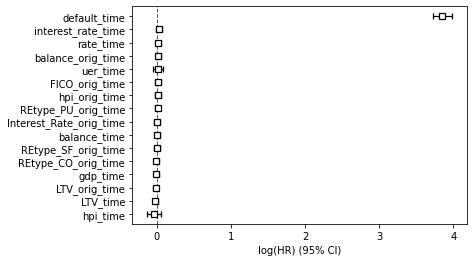

In [164]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(df3, id_col="id", event_col="status_time", start_col="start", stop_col="time", show_progress=True )
ctv.print_summary() #summary of the fitted model with different values of the parametric partial hazard and Partial AIC
ctv.plot() #visiualizaton of the covariates and how they are distributed
ctv.predict_partial_hazard(df3_test) #predicting the partial hazard

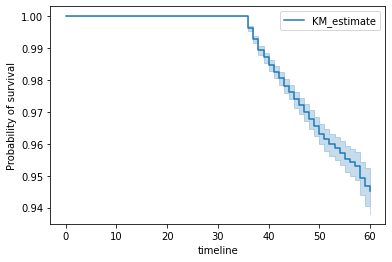

In [165]:
survival = KaplanMeierFitter() #
survival.fit(df3['time'], df3['default_time']) #Survival Curve for our dataset
survival.plot() #plot the Curve
plt.ylabel("Probability of survival")
plt.show()
plt.close()

In [166]:
concordance_index(df3_test['time'], ctv.predict_partial_hazard(df3_test)) #calculate the C-Index

0.26230567093029866

In [ ]:
concordance_index()

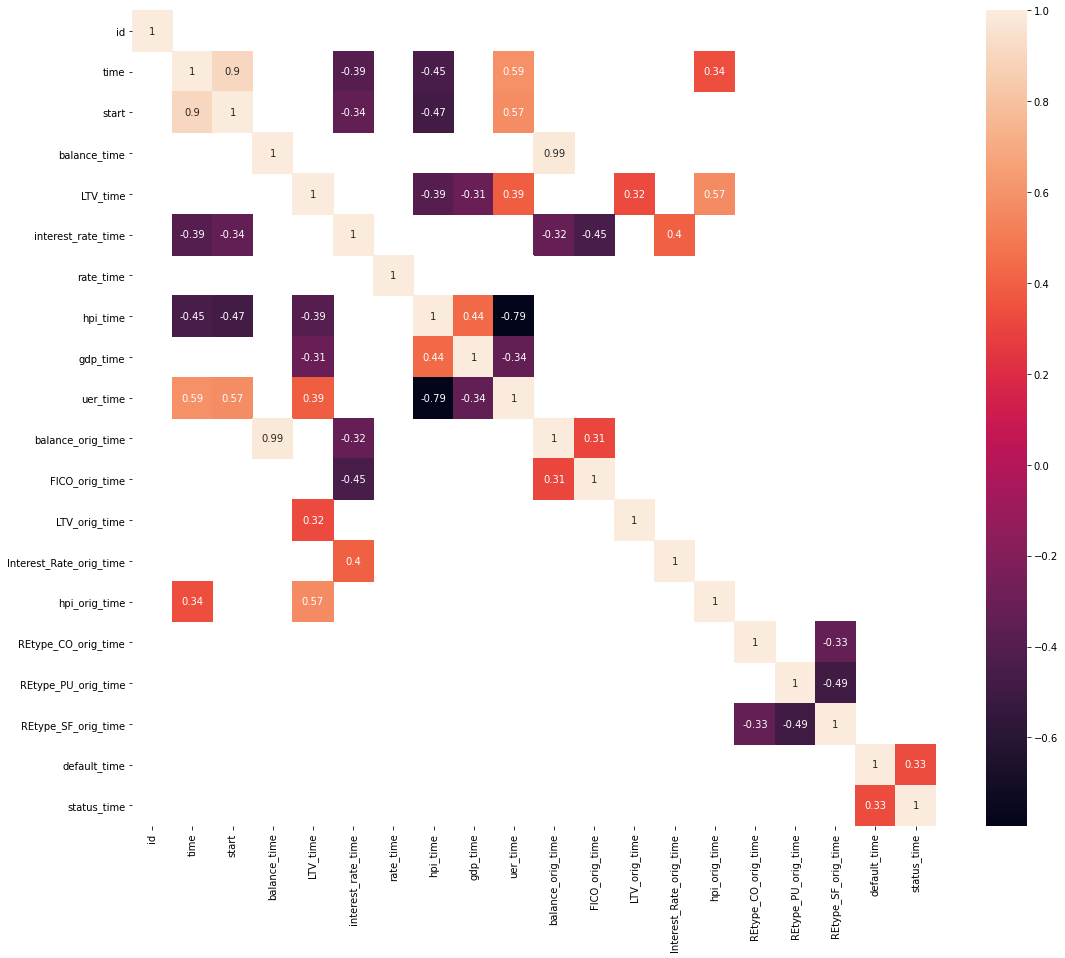

In [40]:
import seaborn as sns

corr= df3.corr()

f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)], #plot a correlation heatmap with only values exceeding absolute 0.30
            annot=True);